# Data Preparation

In [1]:
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np
import cv2
import random

Functions

In [6]:
# for part 1

def plotFewSamples(samples):
    for i in range(9):	
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(samples[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

def plotFewBinarySamples(samples,filename):
    for i in range(9):	
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(setMatRange(samples[i]), cmap=pyplot.get_cmap('gray'))
    pyplot.savefig(filename)
    pyplot.show()

def plotFewCompositeSamples(samples,filename,index):
    for i in range(9):	
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(setMatRange(samples[i,:,:,index]), cmap=pyplot.get_cmap('gray'))
    pyplot.savefig(filename)
    pyplot.show()

def plotImagesWithCircles(samples,no_of_samples,no_in_row):
    images = []
    img = []
    color = (255,0,0)
    for i in range(no_of_samples):
        tempimg = samples[i,:,:]
        drawing = setMatRange(tempimg)
        tempimg = np.array(tempimg).astype(np.uint8)
        drawing = np.array(drawing).astype(np.uint8)

        _, contours, hierarchy = cv2.findContours(tempimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        (x,y), r = cv2.minEnclosingCircle(contours[0])
#         print('Len of contours = ',len(contours))
#         if len(contours)>1:
#             for c in contours:
#                 print(len(c))
        contours_poly = cv2.approxPolyDP(contours[0], 3, True)
        cv2.drawContours(drawing, contours_poly, 0, color)
        cv2.circle(drawing, (int(x), int(y)), int(r), color, 2)

        if(img == []):
            img = drawing
        else :
            img = np.hstack((img, drawing))
            
        if (img.shape[1] /28 == no_in_row):
            if(images == []):
                images = img.copy()
                img = []
            else:
                images = np.vstack((images, img))
                img = []
    cv2.imwrite('q3_data.jpg', images)
    cv2.imshow('q3_data', images)
    cv2.waitKey()
    cv2.destroyAllWindows()

def applyTSS(mat):
    # 	print('In TSS image, ',mat.shape)

    MIN_PIXEL_SUM = 10000000000
    OTSU_THRESH = -1
    unique_values = np.unique(mat)

    for i in range(len(unique_values)):
        temp_thresh = unique_values[i]
        pos1 = mat>=temp_thresh
        pos2 = mat<temp_thresh

        l1 = np.array([])
        l2 = np.array([])
        
        if pos1.any():
            l1 = np.array(mat[pos1]).ravel()
        if pos2.any():
            l2 = np.array(mat[pos2]).ravel()

        val=1000000
        
        if len(l1)!=0 and len(l2)!=0:
            val = np.var(l1)*l1.shape[0] + np.var(l2)*l2.shape[0]
        elif len(l1)!=0:
            val = np.var(l1)*l1.shape[0]
        else:
            val = np.var(l2)*l2.shape[0]
        
#         if len(l1)!=0 and len(l2)!=0:
#             val = np.var(l1)*l1.shape[0] + np.var(l2)*l2.shape[0]
#         elif len(l1)!=0:
#             val = np.var(l1)*l1.shape[0]
#         else:
#             val = np.var(l2)*l2.shape[0]
        # print(val,MIN_PIXEL_SUM)

        if(val<MIN_PIXEL_SUM):
            OTSU_THRESH=temp_thresh
            MIN_PIXEL_SUM =val

    binary_mask = np.zeros(mat.shape)
    binary_mask[mat>=OTSU_THRESH] = 1
    return binary_mask

def computeBinaryMasks(samples):
    binary_masks = np.zeros(samples.shape)
    for i in range(samples.shape[0]):
        binary_masks[i,:,:] = applyTSS(samples[i,:,:])
    return binary_masks

def setMatRange(mat):
    max_value = np.max(mat)
    mat = mat / max_value * 255
    return mat

def saveNumpyArray(a,filename):
    np.save(filename, a)

def loadNumpyArray(filename):
    return np.load(filename+'.npy')

# for part 2

def findMinEnclosingCircle(samples):
    circle_details = np.zeros((samples.shape[0],3))
    for i in range(samples.shape[0]):
        curr_img = np.array(samples[i,:,:]).astype(np.uint8)
        _, contours, hierarchy = cv2.findContours(curr_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        (x,y), r = cv2.minEnclosingCircle(contours[0])
#         print('Len of contour is ',len(contours))
        circle_details[i,0] = x
        circle_details[i,1] = y
        circle_details[i,2] = r
    return circle_details


# for part 3

def getConcatenatedMat(samples,ind1,ind2,ind3,ind4):
    topimg = np.hstack((samples[ind1,:,:],samples[ind2,:,:]))
    botimg = np.hstack((samples[ind3,:,:],samples[ind4,:,:]))
    return np.vstack((topimg,botimg))

def getBackgroundMat(mat):
    mat = mat + 1
    mat[mat==2] = 0
    return mat

def form4imagesDataset(samples,binary_masks,truth_labels,total_no):
    sizex = samples.shape[1]
    composite_images = np.zeros((total_no,sizex*2,sizex*2,12))
    datasize = samples.shape[0]
    
    for i in range(total_no):
        img1_index = random.randint(0,datasize-1)
        img2_index = random.randint(0,datasize-1)
        img3_index = random.randint(0,datasize-1)
        img4_index = random.randint(0,datasize-1)
        
        # 0 index for original image
        # 1 to 10 for foreground
        # 11 index for background
        
        # input image, grayscale one
        composite_images[i,:,:,0] = getConcatenatedMat(samples,img1_index,img2_index,img3_index,img4_index)        
        
        img1_label = truth_labels[img1_index]
        img2_label = truth_labels[img2_index]
        img3_label = truth_labels[img3_index]
        img4_label = truth_labels[img4_index]
        
        composite_images[i,0:sizex,0:sizex,img1_label+1] = binary_masks[img1_index,:,:]         
        composite_images[i,0:sizex,sizex:2*sizex,img2_label+1] = binary_masks[img2_index,:,:] 
        composite_images[i,sizex:2*sizex,0:sizex,img3_label+1] = binary_masks[img3_index,:,:] 
        composite_images[i,sizex:2*sizex,sizex:2*sizex,img4_label+1] = binary_masks[img4_index,:,:]
        
        # background pixels
        background = getConcatenatedMat(binary_masks,img1_index,img2_index,img3_index,img4_index)
        composite_images[i,:,:,11] = getBackgroundMat(background)
    return composite_images


In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('Showing some stats for the data..')
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

Showing some stats for the data..
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


## 1.1 Prepare Data For Q2

In [5]:
print('Computing the binary masks for training data....')
binary_masks_trainX = computeBinaryMasks(train_X)
print('Computing the binary masks for testing data....')
binary_masks_testX = computeBinaryMasks(test_X)

print('\nPlotting some results for the visualistion..')
plotFewBinarySamples(binary_masks_trainX,'q2_dataset_plots')

print('saving the results')
saveNumpyArray(binary_masks_trainX,'q2dataset_train')
saveNumpyArray(binary_masks_testX,'q2dataset_test')

Computing the binary masks for training data....
Computing the binary masks for testing data....

Plotting some results for the visualistion..
saving the results


## 1.2 Prepare Data For Q3

In [10]:
print('Loading the data from 1.1')
binary_masks_trainX = loadNumpyArray('q2dataset_train')
binary_masks_testX = loadNumpyArray('q2dataset_test')
print(binary_masks_trainX.shape)
print(binary_masks_testX.shape)


print('Calculating center and radius of binary masks of train X..')
cen_rad_trainX = findMinEnclosingCircle(binary_masks_trainX)
print('Calculating center and radius of binary masks of test X..')
cen_rad_testX = findMinEnclosingCircle(binary_masks_testX)


# saving the results
print('saving the results')
saveNumpyArray(cen_rad_trainX,'q3dataset_cen_rad_train')
saveNumpyArray(cen_rad_testX,'q3dataset_cen_rad_test')

Calculating center and radius of binary masks of train X..
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  3
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  3
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  3
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  3
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

Len of contour is  1
Len of contour is  4
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  4
Len of contour is  4
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  3
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  2
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contour is  1
Len of contou

In [44]:
# displaying the results
print(binary_masks_trainX.shape)
print(binary_masks_testX.shape)
plotImagesWithCircles(binary_masks_trainX.copy(),100,10)

## 1.3 Prepare Data for Q4

Loading the data from 1.1 and printing shapes of train and test
(60000, 28, 28)
(10000, 28, 28)

Finding the composite images
Training data shape =  (5000, 56, 56, 12)
Testing data shape =  (1000, 56, 56, 12)


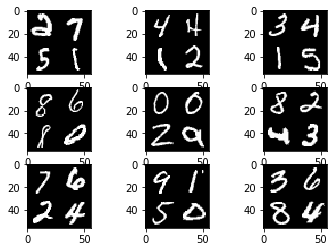

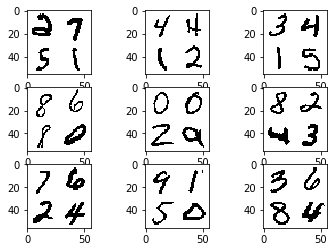

saving the results


In [7]:
print('Loading the data from 1.1 and printing shapes of train and test')
binary_masks_trainX = loadNumpyArray('q2dataset_train')
binary_masks_testX = loadNumpyArray('q2dataset_test')
print(binary_masks_trainX.shape)
print(binary_masks_testX.shape)
print()

train_size = 5000
test_size = 1000

print('Finding the composite images')
composite_images_trainX = form4imagesDataset(train_X,binary_masks_trainX, train_y,train_size)
print('Training data shape = ',composite_images_trainX.shape)
composite_images_testX = form4imagesDataset(test_X,binary_masks_testX, test_y,test_size)
print('Testing data shape = ',composite_images_testX.shape)


#plotting the results
plotFewCompositeSamples(composite_images_trainX,'q4_dataset.png',0)
plotFewCompositeSamples(composite_images_trainX,'q4_dataset_background.png',-1)

# saving the results
print('saving the results')
saveNumpyArray(composite_images_trainX,'q4dataset_composite_imgs_train')
saveNumpyArray(composite_images_testX,'q4dataset_composite_imgs_test')

# Done
